To use with CoLab notebooks, upload the data files manually.

In [1]:
import os, re
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
from scipy import signal, stats


## Find local data filenames ##

In [2]:

# data_dir = '.' # colab manual import
data_dir = '/Users/walter/Data/margolis/MED64_exampledata_03-18/' # walter local

files = os.listdir(data_dir)

re_units = re.compile(r'^units.*')
re_tx = re.compile(r'^treatmentinfo.*')
re_expr_id = re.compile(r"([0-9]{3}_[0-9]{2}h[0-9]{2}m[0-9]{2}s)\.['csv|mat']{3}")

unit_files = dict()
tx_files = dict()

for file in files:
    expr_id = re_expr_id.findall(file)
    if expr_id:
        units_file = re_units.findall(file)
        if units_file:
            unit_files[expr_id[0]] = units_file[0]
        tx_file = re_tx.findall(file)
        if tx_file:
            tx_files[expr_id[0]] = tx_file[0]
expt_list = sorted(list(unit_files.keys()))

print('FOUND DATA FILES:')
print('Experiment IDs: \n\t' + '\n\t'.join(expt_list))
print('Units Files: \n\t' + '\n\t'.join(unit_files.values()))
print('Treatment Files: \n\t' + '\n\t'.join(tx_files.values()))


FOUND DATA FILES:
Experiment IDs: 
	825_12h24m37s
	825_13h36m25s
	825_15h01m13s
	825_16h06m19s
	827_12h06m26s
	827_13h30m23s
	827_15h57m53s
Units Files: 
	units_825_12h24m37s.mat
	units_827_15h57m53s.mat
	units_825_13h36m25s.mat
	units_827_13h30m23s.mat
	units_827_12h06m26s.mat
	units_825_16h06m19s.mat
	units_825_15h01m13s.mat
Treatment Files: 
	treatmentinfo2020_825_13h36m25s.csv
	treatmentinfo2020_827_13h30m23s.csv
	treatmentinfo2020_827_12h06m26s.csv
	treatmentinfo2020_825_12h24m37s.csv
	treatmentinfo2020_827_15h40m00s.csv
	treatmentinfo2020_827_15h57m53s.csv
	treatmentinfo2020_825_16h06m19s.csv
	treatmentinfo2020_825_15h01m13s.csv


## Read datafiles ##

Note: The matlab file for the waveform is imported as a column array. To transpose the waveform array W use `np.transpose(W)[0]`

In [3]:
def read_tx_file(tx_filename):
    tx_times = dict()
    with open(tx_filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)
        for row in csvReader:
            tx_times[row[1]] = float(row[0])
    return tx_times

def extract_units_mat_data(units_mat):
    """extract timestamps into flatter structure from units_xxx.mat file"""
    TS = 0
    MWAVE = 1
    num_units = units_mat['Unit'][0].shape[0] 
    timestamps = dict()
    for u in range(num_units):
        timestamps[u] = dict()
        timestamps[u]['timestamps'] = np.sort(units_mat['Unit'][0][u][TS][0])
        timestamps[u]['waveform'] = units_mat['Unit'][0][u][MWAVE]
    return timestamps

def read_units_file(unit_filename):
    units_mat = scipy.io.loadmat(unit_filename)
    return extract_units_mat_data(units_mat)

In [4]:
expt_id = expt_list[0]

# data_dir = '/content/' # colab
data_dir = '/Users/walter/Data/margolis/MED64_exampledata_03-18/' # walter local

tx_filename = data_dir + tx_files[expt_id]
tx_times = read_tx_file(tx_filename)

unit_filename = data_dir + unit_files[expt_id]
units_data = read_units_file(unit_filename)

## Rug Plots ##

In [5]:
def rug_thinning_factor(num_ts):
    """returns thinning factor for optimal visualization of rug.
    use return value as index slicing step size.
    """
    max_ts_num = 150
    if num_ts <= max_ts_num:
        return 1
    return int(num_ts / max_ts_num)

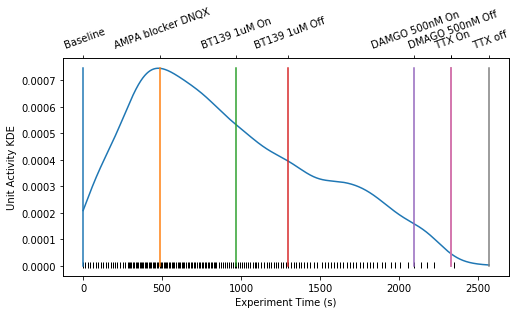

In [6]:
def plot_expt_timecourse(timestamps):
    num_ts = units_data[UNIT]['timestamps'].shape[0]

    # create function for density
    density = stats.kde.gaussian_kde(timestamps)

    fig, ax1 = plt.subplots(figsize=(8,4))
    ax2 = ax1.twiny()

    # plot kernel density
    x = np.arange(timestamps.min(), timestamps.max(), 0.1)
    kde_x = density(x)
    ax1.plot(x, kde_x)

    # plot rug
    thin_rug = rug_thinning_factor(num_ts) # improves visualization, make func
    rug_height = kde_x.min()
    ax1.plot(timestamps[::thin_rug], [rug_height]*len(timestamps[::thin_rug]), '|', color='k');

    # plot treatment boundary times
    density_range = np.linspace(0, kde_x.max(), num=2)

    for tx, tx_time in tx_times.items():
        ax2.plot((tx_time * np.ones(2)), density_range)
    

    ax1.set_ylabel('Unit Activity KDE')
    ax1.set_xlabel('Experiment Time (s)')
    ax2.set_xticks(list(tx_times.values()))
    ax2.set_xticklabels(list(tx_times.keys()), rotation=20);


UNIT = 0
timestamps = units_data[UNIT]['timestamps']
plot_expt_timecourse(timestamps)


## Cross-Correlation ##
cross-correlation of units with -5 ms to +5 ms lag in 1ms bins

## correlation ##
The correlation can be taken for different times in the experiment to see if neurons are uncorrelated at all times. How likely is it they would become correlated mid experiment? maybe if a silent neuron was included in the signal of a second neuron and only the silent neuron was correlate with a third unit?

- make arrays from hand. use index of second [5:-5] and mode "valid"
- if too large, divide array into time. look at autocorr cross-corr across time.

In [7]:
# constants
bins_per_sec = 1000 # make 1000 for 1Hz analysis
lag_bins = 5
lag_bins_ms = np.arange(-lag_bins, lag_bins + 1) * (1000 / bins_per_sec)


def get_array_from_ts(timestamps, ts_index_max=None):
    if not ts_index_max:
        ts_index_max = int(timestamps.max() * bins_per_sec) + 1
    ts_array = np.zeros(ts_index_max)
    ts_event_indices = (timestamps * bins_per_sec).astype(int)

    for i in ts_event_indices:
        ts_array[i] += 1
    return ts_array

def autocorr(timestamps):
    """return the auto-correlation of a list of time stamps of activity.
    The auto-correlation is done at 1 ms resolution and -5 to +5 ms lags.
    RETURN array of auto-correlation values in 1 ms bins from -5 to +5 sliding
    lag.
    """
    ts_array = get_array_from_ts(timestamps)
    ts_arr_lag = ts_array[lag_bins:-lag_bins]
    autocorr = (signal.correlate(ts_array, ts_arr_lag, mode = 'valid') 
                / (ts_array.sum() + 1))
    return autocorr

def crosscorr(timestamps_a, timestamps_b):
    """return the cross-correlation of two list of time stamps of activities
    """
    ts_max = np.append(timestamps_a, timestamps_b).max()
    ts_index_max = int(ts_max * bins_per_sec) + 1

    ts_array_a = get_array_from_ts(timestamps_a, ts_index_max)
    ts_array_b = get_array_from_ts(timestamps_b, ts_index_max)
    ts_arr_b_lag = ts_array_b[lag_bins:-lag_bins]
    crosscorr = (signal.correlate(ts_array_a, ts_arr_b_lag, mode = 'valid') 
                / (ts_array_a.sum() + 1))
    return crosscorr

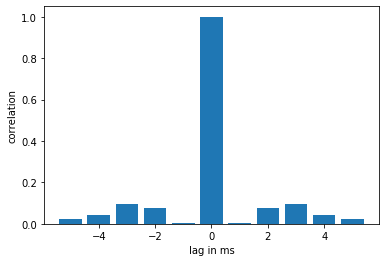

In [8]:
unit_a = 2
unit_b = 2
# crosscorrs_units[unit_a][unit_b] 
crosscorrs_units = crosscorr(units_data[unit_a]['timestamps'],
                             units_data[unit_b]['timestamps'])

plt.bar(lag_bins_ms, crosscorrs_units)
plt.xlabel('lag in ms')
plt.ylabel('correlation');

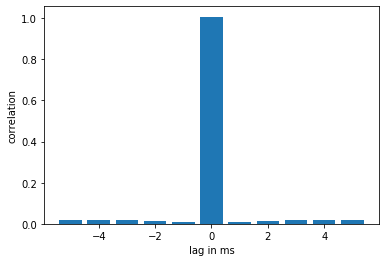

In [9]:
# execute funtions
# ts_example = np.sort(unit_mat['Unit'][0][COL][TS][0])

UNIT = 1
autocorrs_units = dict()
autocorrs_units[UNIT] = autocorr(units_data[UNIT]['timestamps'])

plt.bar(lag_bins_ms, autocorrs_units[UNIT])
plt.xlabel('lag in ms')
plt.ylabel('correlation');

# Grid plots
Showing multiple units for each experiment

In [10]:
def make_grid_array(num_units):
    """takes any number of units >3 and returns an array of indices
    for ploting a grid of units
    """
    max_cols = 4
    x=np.arange(num_units)
    dim2 = min(int(np.floor(np.sqrt(num_units))), max_cols)
    dim1 = int(np.ceil(num_units / dim2))
    x.resize(dim1*dim2)
    x.shape
    return x.reshape(dim1,dim2)

grid_arr = make_grid_array(5)
print(grid_arr.shape)
grid_arr

(3, 2)


array([[0, 1],
       [2, 3],
       [4, 0]])

In [11]:
# display grid array variables
grid_array = make_grid_array(5)
for row, cols in enumerate(grid_array):
    for col, unit in enumerate(cols):
        print(unit, row, col)

0 0 0
1 0 1
2 1 0
3 1 1
4 2 0
0 2 1


Grid plot of experiment timecourse

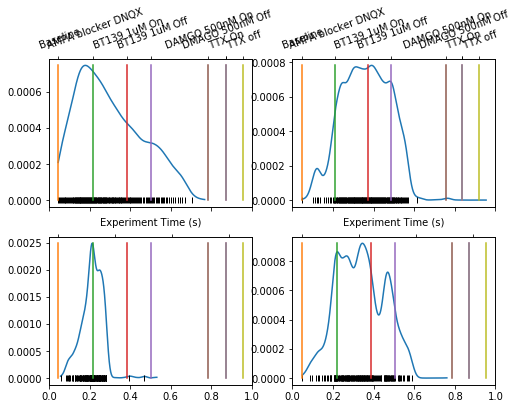

In [12]:
num_units = 4 #len(units_data.keys())
grid_array = make_grid_array(num_units)
nrows, ncols = grid_array.shape

fig, axs1 = plt.subplots(*grid_array.shape, sharex='all', figsize=(ncols*4,nrows*3))
axs2 = axs1 

for row, cols in enumerate(grid_array):
    for col, unit in enumerate(cols):
        if not (unit == 0 and col != 0):
            
            timestamps = units_data[unit]['timestamps']

#             num_ts = units_data[unit]['timestamps'].shape[0]
            num_ts = timestamps.shape[0]

            # create function for density
            density = stats.kde.gaussian_kde(timestamps)

            # plot kernel density
            x = np.arange(timestamps.min(), timestamps.max(), 0.1)
            kde_x = density(x)
            axs2[row, col] = axs1[row, col].twiny()
            axs1[row, col].plot(x, kde_x)

            # plot rug
            thin_rug = rug_thinning_factor(num_ts) # improves visualization, make func
            rug_height = kde_x.min()
            axs1[row, col].plot(timestamps[::thin_rug], [rug_height]*len(timestamps[::thin_rug]), '|', color='k');

            # plot treatment boundary times
            density_range = np.linspace(0, kde_x.max(), num=2)

            for tx, tx_time in tx_times.items():
                axs2[row, col].plot((tx_time * np.ones(2)), density_range)
                axs2[row, col].set_xticklabels([]);

            if col == 0:
                axs1[row, col].set_ylabel('Unit Activity KDE')
            if row == (nrows-1):
                axs1[row, col].set_xlabel('Experiment Time (s)')
            if row == 0:
                axs2[row, col].set_xticks(list(tx_times.values()))
                axs2[row, col].set_xticklabels(list(tx_times.keys()), rotation=20);


## Plot array of auto-correlograms ##

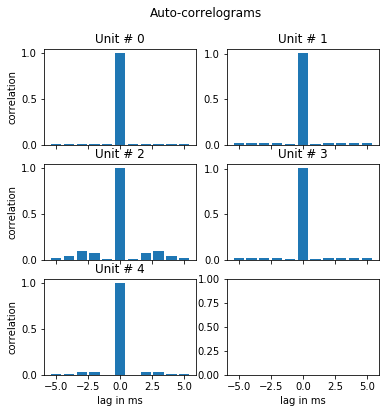

In [13]:
# works for min of 4 plots

# AUTO-CORRELOGRAM
num_units = 5 #len(units_data.keys())
grid_array = make_grid_array(num_units)
nrows, ncols = grid_array.shape

autocorrs_units = dict()

fig, axs = plt.subplots(*grid_array.shape, sharex='all', figsize=(ncols*3,nrows*2))

for row, cols in enumerate(grid_array):
    for col, unit in enumerate(cols):
        if not (unit == 0 and col != 0):
            autocorrs_units[unit] = autocorr(units_data[unit]['timestamps'])
            axs[row, col].bar(lag_bins_ms, autocorrs_units[unit])      
            axs[row, col].set_title('Unit # ' + str(unit)) 
        if row == (nrows-1):
            axs[row, col].set_xlabel('lag in ms')
        if col == 0:
            axs[row, col].set_ylabel('correlation')
plt.suptitle('Auto-correlograms', y=(1 - 0.008*nrows));


## Plot array of cross-correlograms ##

## Dirty units
In datafile units_825_12h24m37s.mat, Units 4 and 19 in cross-correlograms look like they are sharing some activity. correlation at zero lag is only 0.015. However, this is more than 10x the other lag times.

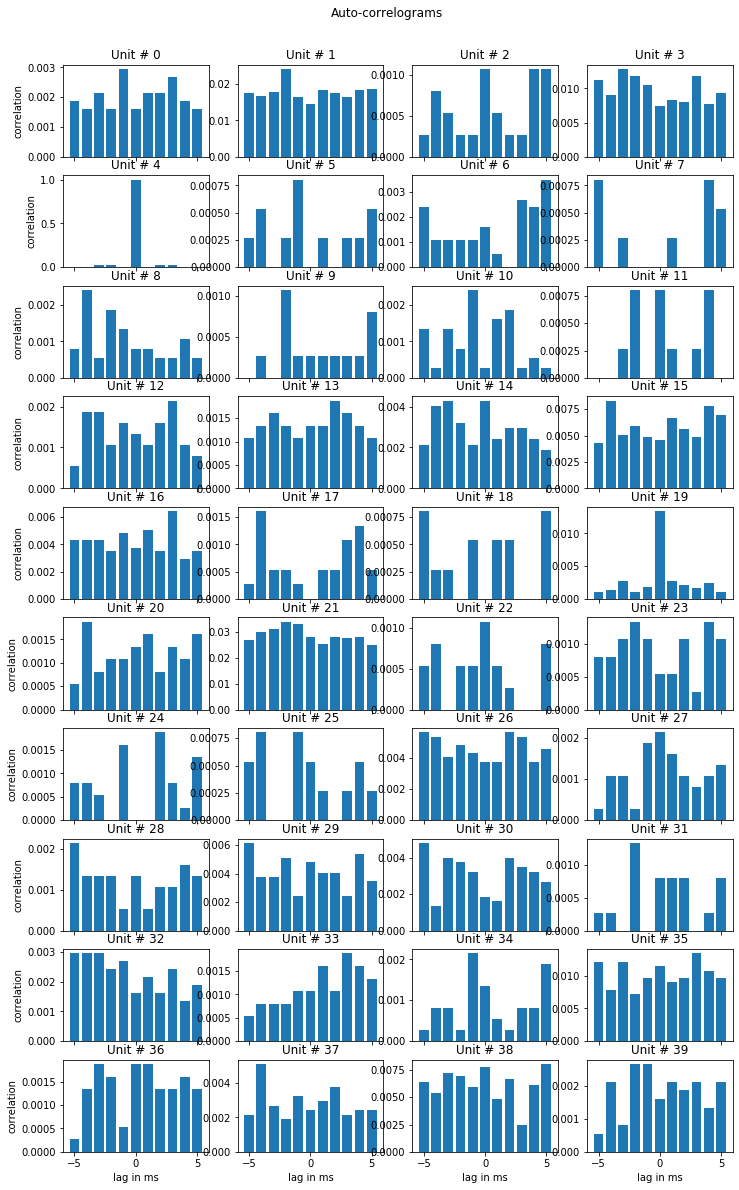

In [14]:
# CROSS
reference_unit = 4

num_units = 40 #len(units_data.keys())
grid_array = make_grid_array(num_units)
nrows, ncols = grid_array.shape

crosscorrs_units = dict()

fig, axs = plt.subplots(*grid_array.shape, sharex='all', figsize=(ncols*3,nrows*2))

for row, cols in enumerate(grid_array):
    for col, unit in enumerate(cols):
        if not (unit == 0 and col != 0):
            crosscorrs_units[unit] = crosscorr(units_data[reference_unit]['timestamps'],
                                         units_data[unit]['timestamps'])
            axs[row, col].bar(lag_bins_ms, crosscorrs_units[unit])     
            axs[row, col].set_title('Unit # ' + str(unit)) 
        if row == (nrows-1):
            axs[row, col].set_xlabel('lag in ms')
        if col == 0:
            axs[row, col].set_ylabel('correlation')
plt.suptitle('Auto-correlograms', y=(1 - 0.008*nrows));


## Plot array of waveforms ##

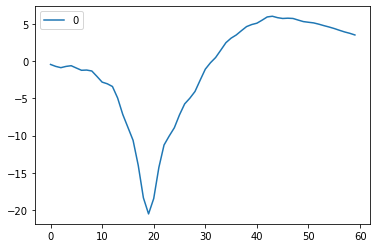

In [15]:
UNIT = 19
sns.lineplot(data = units_data[UNIT]['waveform'])


## plot arrays of waveforms and cross-correlations ##

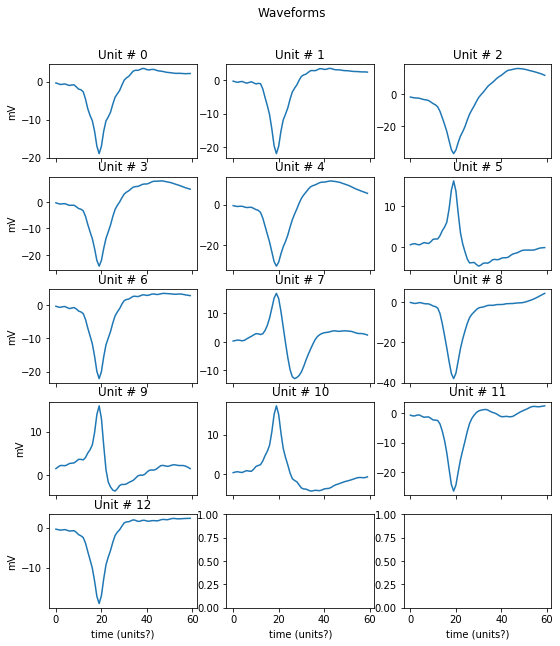

In [16]:
# works for min of 4 plots

num_units = 13 # len(units_data.keys())
grid_array = make_grid_array(num_units)
nrows, ncols = grid_array.shape


fig, axs = plt.subplots(*grid_array.shape, sharex='all', figsize=(ncols*3,nrows*2))

for row, cols in enumerate(grid_array):
    for col, unit in enumerate(cols):
        if not (unit == 0 and col != 0):
            axs[row, col].plot(units_data[unit]['waveform'])
            axs[row, col].set_title('Unit # ' + str(unit)) #text(0,0, ('Unit # ' + str(unit))
        if row == (nrows-1):
            axs[row, col].set_xlabel('time (units?)')
        if col == 0:
            axs[row, col].set_ylabel('mV')
plt.suptitle('Waveforms', y=(1 - 0.008*nrows));
